1) Finding Relevant Data 

In [1]:
import folium
import pandas as pd
from shapely.geometry import Polygon

# PART 1 - VISUALIZATION
# Function to add markers to the map
# Dataset obtained from https://www.alltrails.com
# Code cited from https://realpython.com/python-folium-web-maps-from-data/
def add_markers(data, map_object, icon_color='blue'):
    for _, row in data.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            icon=folium.Icon(color=icon_color),
            popup=f"{row.get('Name', 'No Name')}"  # Assuming there might be a 'Name' column
        ).add_to(map_object)

# Load initial trail data
trail_data_path = '/Users/brianmmari/Downloads/MCSA Hut via Kasteelspoort Trail.csv'
MCSA_Trail = pd.read_csv(trail_data_path)

# Calculate the average location for centering the map
average_lat = MCSA_Trail['Latitude'].mean()
average_lon = MCSA_Trail['Longitude'].mean()
map = folium.Map(location=[average_lat, average_lon], zoom_start=12)  # Adjust zoom for better detail

# Add markers for the initial trail data
add_markers(MCSA_Trail, map, icon_color='green')


# Paths to additional CSV files
csv_paths = [
    '/Users/brianmmari/Downloads/Cape Point Overnight Hike.csv',
    '/Users/brianmmari/Downloads/Hoerikwaggo Trail_ Day 4.csv',
    '/Users/brianmmari/Downloads/Hoerikwaggo Trail_ Day 2.csv'
]
colors = ['green','red', 'blue', 'purple']  # Different colors for each dataset

# Load and add markers for additional CSV data
for csv_path, color in zip(csv_paths, colors):
    additional_data = pd.read_csv(csv_path)
    add_markers(additional_data, map, icon_color=color)

# Add layer control to toggle layers on/off
folium.LayerControl().add_to(map)

# Save the map as an HTML file
map.save('map.html')

In [2]:
# Dataset obtained from https://www.ncei.noaa.gov/cdo-web/orders?email=brianmmari@princeton.edu&id=3668862
# Specify the column names that you expect
columns = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN']

# Read the CSV file
climate_dataset = pd.read_csv(
    '/Users/brianmmari/Library/CloudStorage/OneDrive-PrincetonUniversity/original_dataset.csv', 
    usecols=columns,  low_memory=False
)

# Display the first few rows to verify
print(climate_dataset.head())

       STATION         NAME  LATITUDE  LONGITUDE  ELEVATION        DATE  PRCP  \
0  SF003724960  VRYHEID, SF   -27.783       30.8     1163.0  01/01/2012  0.11   
1  SF003724960  VRYHEID, SF   -27.783       30.8     1163.0  02/01/2012  0.11   
2  SF003724960  VRYHEID, SF   -27.783       30.8     1163.0  05/01/2012  0.03   
3  SF003724960  VRYHEID, SF   -27.783       30.8     1163.0  06/01/2012  0.05   
4  SF003724960  VRYHEID, SF   -27.783       30.8     1163.0  07/01/2012  0.00   

   TAVG  TMAX TMIN  
0  73.0  86.0   63  
1  74.0  86.0   64  
2  74.0  88.0   67  
3  75.0  85.0   66  
4  74.0  85.0   66  


2) Data Cleaning & Preparation

In [3]:
# First, Renaming the columns
climate_dataset.rename(columns={'PRCP': 'Precipitation', 'TAVG': 'Average Temperature', 'TMAX':'Maximum Temperature', 'TMIN':'Minimum Temperature', 'LATITUDE':'Latitude', 
                                'LONGITUDE': 'Longitude', 'DATE' : 'Date'}, inplace=True)

# Dropping columns, we don't need
climate_dataset.drop(columns=['STATION', 'NAME'], inplace=True)


# Now df has the column 'old_name1' renamed to 'new_name1'
climate_dataset.head()
print(climate_dataset.shape)


(169240, 8)


In [4]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Function to create a GeoDataFrame from trail CSV
# Paths to trail CSV files
# Additional trail data paths defined as variables
# Code cited from https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
cape_point_path = '/Users/brianmmari/Downloads/Cape Point Overnight Hike.csv'
hoerikwaggo_day4_path = '/Users/brianmmari/Downloads/Hoerikwaggo Trail_ Day 4.csv'
hoerikwaggo_day2_path = '/Users/brianmmari/Downloads/Hoerikwaggo Trail_ Day 2.csv'
 
# Update csv_paths to include all paths
csv_paths = [
    trail_data_path,  
    cape_point_path, 
    hoerikwaggo_day4_path,  
    hoerikwaggo_day2_path   
]

trail_names = [
    "MCSA Hut via Kasteelspoort Trail",
    "Cape Point Overnight Hike",
    "Hoerikwaggo Trail: Day 4",
    "Hoerikwaggo Trail: Day 2"
]

# Convert Trail and Climate Data into GeoDataFrames:
def create_trail_gdf(csv_path, trail_name):
    data = pd.read_csv(csv_path)
    if not (data.iloc[0]['Latitude'] == data.iloc[-1]['Latitude'] and data.iloc[0]['Longitude'] == data.iloc[-1]['Longitude']):
        data = pd.concat([data, data.iloc[[0]]]).reset_index(drop=True)
    polygon = Polygon([(row['Longitude'], row['Latitude']) for _, row in data.iterrows()])
    gdf = gpd.GeoDataFrame([{'geometry': polygon, 'Name': trail_name}], crs="EPSG:4326")
    return gdf

In [5]:
# Load climate data 
climate_points = gpd.GeoDataFrame(climate_dataset, geometry=gpd.points_from_xy(climate_dataset.Longitude, climate_dataset.Latitude), crs="EPSG:4326")


# Process each trail file
trail_gdfs = []
for csv_path, trail_name in zip(csv_paths, trail_names):
    trail_gdf = create_trail_gdf(csv_path, trail_name)
    trail_gdfs.append(trail_gdf)

# Combine all trail GeoDataFrames into one
all_trails_gdf = gpd.GeoDataFrame(pd.concat(trail_gdfs, ignore_index=True), crs="EPSG:4326")
all_trails_gdf.head()


,geometry,Name
0,"POLYGON ((18.38412 -33.96305, 18.38426 -33.963...",MCSA Hut via Kasteelspoort Trail
1,"POLYGON ((18.46390 -34.26702, 18.46389 -34.266...",Cape Point Overnight Hike
2,"POLYGON ((18.41150 -34.19053, 18.41144 -34.190...",Hoerikwaggo Trail: Day 4
3,"POLYGON ((18.32007 -34.14586, 18.32029 -34.145...",Hoerikwaggo Trail: Day 2


In [6]:
# Initialize a column for storing the nearest trail name
# Perform spatial join
# Code cited from https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html
joined_data = gpd.sjoin(climate_points, all_trails_gdf, how="left", predicate='within')

climate_dataset['Nearest_Trail_Name'] = pd.NA
climate_dataset['Min_Distance'] = float('inf')

# Calculate the minimum distance to any trail polygon and assign the trail name
for index, trail in all_trails_gdf.iterrows():
    # Compute distances from all points to this particular trail polygon
    distances = climate_points['geometry'].apply(lambda point: point.distance(trail['geometry']))
    
    # Identify points for which this trail is the closest one encountered so far
    mask = distances < climate_dataset['Min_Distance']
    
    # Update the nearest trail name and distance wherever applicable
    climate_dataset.loc[mask, 'Nearest_Trail_Name'] = trail['Name']
    climate_dataset.loc[mask, 'Min_Distance'] = distances[mask]

# Optionally, drop the 'Min_Distance' if you don't need it
climate_dataset.drop(columns=['Min_Distance'], inplace=True)

columns_to_drop = [col for col in climate_dataset.columns if 'Unnamed' in col]

# Drop these columns from the DataFrame
climate_dataset.drop(columns=columns_to_drop, inplace=True)

# Check dataframe
print(climate_dataset.head(20))

    Latitude  Longitude  ELEVATION        Date  Precipitation  \
0    -27.783       30.8     1163.0  01/01/2012           0.11   
1    -27.783       30.8     1163.0  02/01/2012           0.11   
2    -27.783       30.8     1163.0  05/01/2012           0.03   
3    -27.783       30.8     1163.0  06/01/2012           0.05   
4    -27.783       30.8     1163.0  07/01/2012           0.00   
5    -27.783       30.8     1163.0  08/01/2012            NaN   
6    -27.783       30.8     1163.0  09/01/2012            NaN   
7    -27.783       30.8     1163.0  10/01/2012           0.01   
8    -27.783       30.8     1163.0  14/01/2012           0.05   
9    -27.783       30.8     1163.0  16/01/2012           0.70   
10   -27.783       30.8     1163.0  18/01/2012           0.20   
11   -27.783       30.8     1163.0  20/01/2012            NaN   
12   -27.783       30.8     1163.0  21/01/2012            NaN   
13   -27.783       30.8     1163.0  26/01/2012            NaN   
14   -27.783       30.8  

In [7]:
# Load the fire data
# Obtained from https://firms.modaps.eosdis.nasa.gov/country/
fire_data = pd.read_csv('/Users/brianmmari/Library/CloudStorage/OneDrive-PrincetonUniversity/SML_Final Project/fire.csv')

# Define the mapping
confidence_mapping = {
    'l': 0,  # low confidence
    'n': 1,  # nominal confidence
    'h': 2,  # high confidence

}

# Assuming 'df' is your DataFrame and 'confidence' is the column with the categorical data
fire_data['confidence'] = fire_data['confidence'].map(confidence_mapping)

In [8]:
# Same procedure as in climate_dataset:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Assuming the fire data and climate data are already loaded into DataFrame `fire_data` and `climate_dataset`
# Ensure the date format and column names are correct
fire_data['acq_date'] = pd.to_datetime(fire_data['acq_date']).dt.strftime('%d/%m/%Y')
climate_dataset['Date'] = pd.to_datetime(climate_dataset['Date'], format='%d/%m/%Y')
fire_points = gpd.GeoDataFrame(fire_data, geometry=gpd.points_from_xy(fire_data.longitude, fire_data.latitude), crs="EPSG:4326")

# Initialize a column for storing the nearest trail name
# Perform spatial join
joined_data = gpd.sjoin(fire_points, all_trails_gdf, how="left", predicate='within')

fire_data['Nearest_Trail_Name'] = pd.NA
fire_data['Min_Distance'] = float('inf')

# Calculate the minimum distance to any trail polygon and assign the trail name
for index, trail in all_trails_gdf.iterrows():
    # Compute distances from all points to this particular trail polygon
    distances = fire_points['geometry'].apply(lambda point: point.distance(trail['geometry']))
    
    # Identify points for which this trail is the closest one encountered so far
    mask = distances < fire_data['Min_Distance']
    
    # Update the nearest trail name and distance wherever applicable
    fire_data.loc[mask, 'Nearest_Trail_Name'] = trail['Name']
    fire_data.loc[mask, 'Min_Distance'] = distances[mask]

# Optionally, drop the 'Min_Distance' if you don't need it
fire_data.drop(columns=['Min_Distance'], inplace=True)

# Check dataframe
print(fire_data.head(200))


/var/folders/td/yg52fd9j2w3dn5zt40tr44k40000gn/T/ipykernel_41266/2826001712.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  fire_data['acq_date'] = pd.to_datetime(fire_data['acq_date']).dt.strftime('%d/%m/%Y')


      latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0   -28.989683  30.673412      340.71  0.59   0.53  20/01/2012      1216   
1   -28.976429  30.359491      352.47  0.57   0.52  20/01/2012      1216   
2   -28.977262  30.362572      330.28  0.57   0.52  20/01/2012      1216   
3   -28.978546  30.356649      342.39  0.57   0.52  20/01/2012      1216   
4   -29.219717  30.408426      353.72  0.56   0.52  20/01/2012      1216   
..         ...        ...         ...   ...    ...         ...       ...   
195 -33.317001  18.847048      307.47  0.43   0.38  20/01/2012      2334   
196 -33.950287  20.394455      307.11  0.39   0.36  20/01/2012      2334   
197 -33.996090  19.384523      308.81  0.41   0.37  20/01/2012      2335   
198 -33.996857  19.388924      311.28  0.41   0.37  20/01/2012      2335   
199 -34.000225  19.387840      305.70  0.41   0.37  20/01/2012      2335   

    satellite instrument  confidence  version  bright_ti5    frp daynight  \
0         

In [9]:
# Assuming fire_data is your variable
if isinstance(fire_data, pd.DataFrame):
    print("fire_data is a DataFrame.")
else:
    print("fire_data is not a DataFrame.")

# Dropping columns, we don't need
fire_data.drop(columns=['bright_ti4', 'scan', 'track', 'satellite', 'acq_time', 'instrument', 'version','bright_ti5', 'frp',
 'daynight', 'type'], inplace=True)

fire_data is a DataFrame.


In [10]:
fire_data.to_csv('/Users/brianmmari/Library/CloudStorage/OneDrive-PrincetonUniversity/fire_data.csv', index=False)

In [11]:
fire_data = pd.read_csv('/Users/brianmmari/Library/CloudStorage/OneDrive-PrincetonUniversity/fire_data.csv')

# Convert 'acq_date' to datetime to ensure proper grouping
fire_data['acq_date'] = pd.to_datetime(fire_data['acq_date'], format='%d/%m/%Y')


In [12]:
# Group data by 'acq_date' and 'Nearest_Trail_Name'
grouped = fire_data.groupby(['acq_date', 'Nearest_Trail_Name'])

# Define a function to determine the mode of the confidence levels
def get_mode(series):
    return series.mode()[0]  # Use [0] to select the first mode in case there are multiple modes

# Apply the function to get the majority confidence for each group
majority_confidence = grouped['confidence'].agg(get_mode).reset_index()

# Rename the column for clarity
majority_confidence.rename(columns={'confidence': 'majority_confidence', 'acq_date' : 'Date'}, inplace=True)

# Display the result
print(majority_confidence.head())

        Date                Nearest_Trail_Name  majority_confidence
0 2012-01-20         Cape Point Overnight Hike                    1
1 2012-01-20  MCSA Hut via Kasteelspoort Trail                    1
2 2012-01-21         Cape Point Overnight Hike                    1
3 2012-01-21  MCSA Hut via Kasteelspoort Trail                    1
4 2012-01-22         Cape Point Overnight Hike                    1


In [13]:
majority_confidence.to_csv('/Users/brianmmari/Library/CloudStorage/OneDrive-PrincetonUniversity/majority_confidence.csv', index=False)

In [14]:
climate_dataset.shape
print(climate_dataset.columns)
print(majority_confidence.columns)

Index(['Latitude', 'Longitude', 'ELEVATION', 'Date', 'Precipitation',
       'Average Temperature', 'Maximum Temperature', 'Minimum Temperature',
       'Nearest_Trail_Name'],
      dtype='object')
Index(['Date', 'Nearest_Trail_Name', 'majority_confidence'], dtype='object')


In [15]:
# Merging df1 and df2 on 'acq_date' 
merged_df = pd.merge(climate_dataset, majority_confidence, on=['Date'], how='outer')

print(merged_df.columns)

# Check if the columns are equal
print((merged_df['Nearest_Trail_Name_x'] == merged_df['Nearest_Trail_Name_y']).all())


Index(['Latitude', 'Longitude', 'ELEVATION', 'Date', 'Precipitation',
       'Average Temperature', 'Maximum Temperature', 'Minimum Temperature',
       'Nearest_Trail_Name_x', 'Nearest_Trail_Name_y', 'majority_confidence'],
      dtype='object')
False


In [16]:
# Sorting by 'Nearest_Trail_Name'
import numpy as np
trail_fire = merged_df.sort_values(by='Date')

# Resetting index after sorting
trail_fire.reset_index(drop=True, inplace=True)

columns = ['Date','Nearest_Trail_Name_x','Nearest_Trail_Name_y','Latitude', 'Longitude', 'ELEVATION', 'Precipitation', 'Average Temperature', 'Maximum Temperature', 'Minimum Temperature', 'majority_confidence']

trail_fire.to_csv('/Users/brianmmari/Desktop/trail_fire.csv', index=False)



3) Exploratory Data Analysis

Before we begin, it's important to check the type of data we have for all of our features. 

In [17]:
print(trail_fire.columns)
print(trail_fire.head(5))

Index(['Latitude', 'Longitude', 'ELEVATION', 'Date', 'Precipitation',
       'Average Temperature', 'Maximum Temperature', 'Minimum Temperature',
       'Nearest_Trail_Name_x', 'Nearest_Trail_Name_y', 'majority_confidence'],
      dtype='object')
   Latitude  Longitude  ELEVATION       Date  Precipitation  \
0   -27.783     30.800     1163.0 2012-01-01           0.11   
1   -32.833     17.850       67.0 2012-01-01            NaN   
2   -31.467     19.767      975.0 2012-01-01            NaN   
3   -31.917     21.517     1268.0 2012-01-01            NaN   
4   -29.533     30.283     1071.0 2012-01-01           0.61   

   Average Temperature  Maximum Temperature Minimum Temperature  \
0                 73.0                 86.0                  63   
1                 63.0                 72.0                  55   
2                 69.0                 87.0                  47   
3                 75.0                 93.0                  59   
4                 70.0                 

In [18]:
# Exploratory Data Analysis
trail_fire = pd.read_csv('/Users/brianmmari/Desktop/trail_fire.csv')
print(trail_fire.shape)


missing_count = trail_fire['majority_confidence'].isna().sum()
total_rows = trail_fire.shape[0]

missing_percentage = (missing_count / total_rows) * 100
print(f"Percentage of missing values in the target column: {missing_percentage:.2f}%")

(267441, 11)
Percentage of missing values in the target column: 27.64%


/var/folders/td/yg52fd9j2w3dn5zt40tr44k40000gn/T/ipykernel_41266/1108916602.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  trail_fire = pd.read_csv('/Users/brianmmari/Desktop/trail_fire.csv')


Given the percentage of missing values in the target column, it's important to first analyze the target column before we do a 
train_test split.

In [19]:
# Look at the distribution of the target column for every classification value
majority_confidence = trail_fire["majority_confidence"]
majority_confidence.value_counts()

majority_confidence
1.0    191793
0.0      1312
2.0       417
Name: count, dtype: int64

In the next steps, I choose to ignore all the columns with 1's because of the following two reaasons:
1) We  have a more balanced dataset with 0's and 2's than with 1's because of the distribution seen above.
2) I want to have the strongest confidence possible i.e 1 = nominal is less likely for forest fires to happen compared to 2's

In [20]:
# Extreme Filter
filter = trail_fire['majority_confidence'].isin([0, 2])

# Subset of the first dataset with only 0's and 2's 
small_trail = trail_fire[filter]

print(small_trail.shape)

print(small_trail.columns)

missing_count = small_trail['majority_confidence'].isna().sum()

total_rows = small_trail.shape[0]

missing_percentage = (missing_count / total_rows) * 100
print(" Percentage of missing values for target column:" + " " + str(missing_percentage)) # sanity check


(1729, 11)
Index(['Latitude', 'Longitude', 'ELEVATION', 'Date', 'Precipitation',
       'Average Temperature', 'Maximum Temperature', 'Minimum Temperature',
       'Nearest_Trail_Name_x', 'Nearest_Trail_Name_y', 'majority_confidence'],
      dtype='object')
 Percentage of missing values for target column: 0.0


In [21]:
# Do I have enough entries for all the features in the dataset?
# Iterate through each column in the DataFrame
for column in small_trail.columns:
    missing_count = small_trail[column].isna().sum()
    total_rows = small_trail.shape[0]
    missing_percentage = (missing_count / total_rows) * 100
    print(f"Percentage of missing values for {column}: {missing_percentage:.2f}%")

Percentage of missing values for Latitude: 0.00%
Percentage of missing values for Longitude: 0.00%
Percentage of missing values for ELEVATION: 0.00%
Percentage of missing values for Date: 0.00%
Percentage of missing values for Precipitation: 65.18%
Percentage of missing values for Average Temperature: 47.37%
Percentage of missing values for Maximum Temperature: 2.14%
Percentage of missing values for Minimum Temperature: 4.92%
Percentage of missing values for Nearest_Trail_Name_x: 0.00%
Percentage of missing values for Nearest_Trail_Name_y: 0.00%
Percentage of missing values for majority_confidence: 0.00%


Major concern placed on Precipitation and Average Temperature because of the amount of missing entries in these columns. 

Perhaps, use histograms to visualize the feature columns

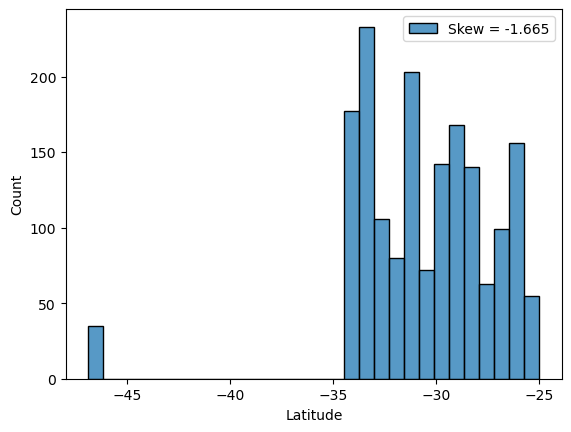

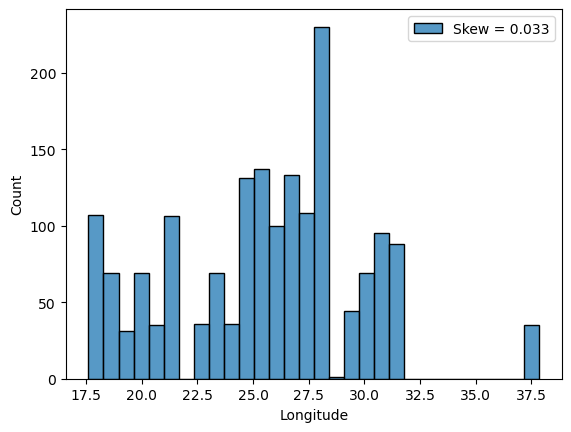

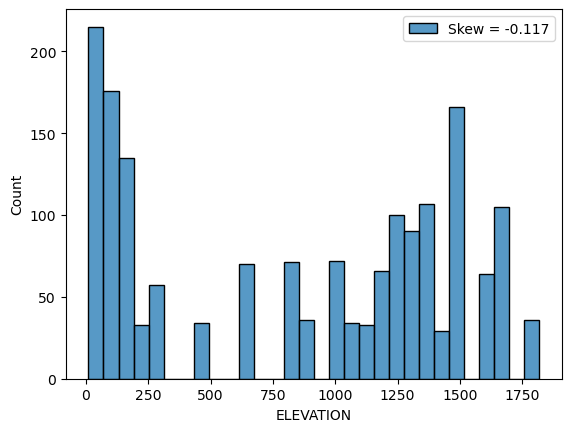

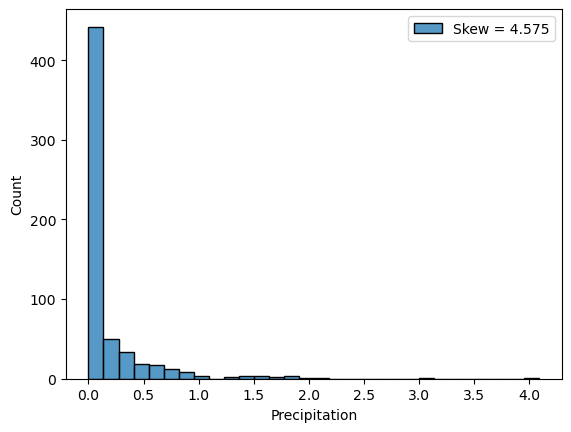

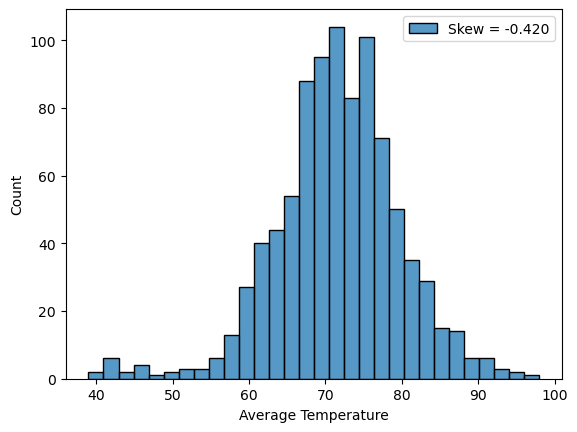

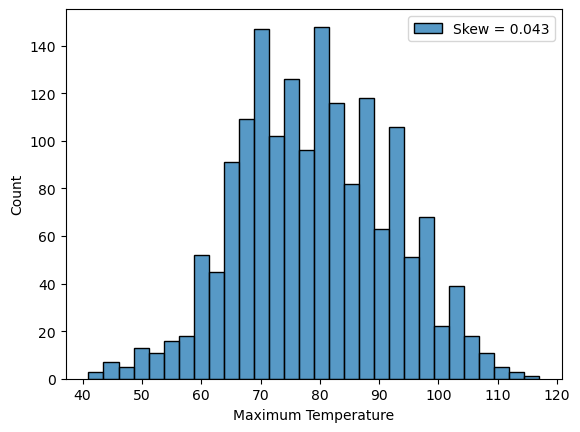

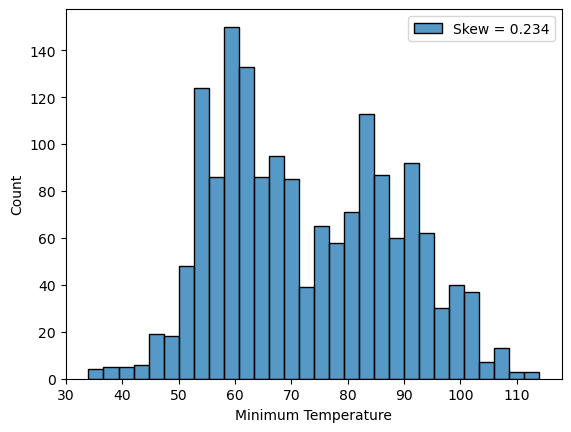

In [22]:
# Analyze all the continous values by creating histograms to understand  
import seaborn as sns
import matplotlib.pyplot as plt
continous_X = small_trail.iloc[:, [0, 1, 2, 4, 5, 6, 7]] 
y = small_trail.iloc[:, -1]  
for feat in continous_X:
    skew = small_trail[feat].skew()
    sns.histplot(small_trail[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()


From the histograms, a few analyses can be done:
1) Precipitation is right-skewed indicating that most of the data is near the lower end of the range, and higher values are infrequent. As a result the median of this data is lower than the mean. However as seen from the histogram we have fewer bars which is expected because about65.48& of our entries are missing in this column

2) Average Temperature is left_skewed indicating that most of the data is near the higher end of the range. As a result the median is higher than the mean. 

3) Maximum Temperature is close to being symmetrical indicating that most of the data is even split between higher and lower ranges.

4) Minimum Temperature is right-skewed which is also almost like a non-symmetric bimodal distribution. 

For all of these histograms, it's important to note that in the modelling features, there's no any outliers. This is a good sanity check. 


Perhaps understand the distribution of the data

In [23]:
import pandas as pd
category_X = small_trail.iloc[:, [3, 8, 9]]

# counts occurrences of each value in the categorical feature - Date
contingency_table = pd.crosstab(index=small_trail['Date'], columns=small_trail['majority_confidence'])

# Sort the contingency table 
sorted_table = contingency_table.sort_values(by=2, ascending=False) 
print(sorted_table.head(10))  # Shows the top entries with the highest occurrences of '2'


majority_confidence  0.0  2.0
Date                         
2016-12-02             0   51
2016-04-17             0   51
2014-04-18             0   49
2015-01-25             0   49
2015-01-08             0   48
2012-01-27             0   43
2012-11-21             0   43
2013-01-18             0   42
2012-12-01             0   41
2014-01-03            51    0


According to the contingency table, the highest confidence factor for forest fires happened most frequently in the following dates:
1)  most frequent times within a year was in 2012

2)  most highest count of forest fires happened in 2016.
    According to the paper, "https://www.sciencedirect.com/science/article/pii/S2212420923000985" the largest fire disasters other than 
    2023-which isn't part of our dataset-happened in 2017

3)  most frequenct months of forest fires happened in January, followed by April & December(tied).
    According to the web, most frequent months of forest fires around western parts of South Africa occur during summer months: Dec - March


In [24]:
from scipy.stats import chi2_contingency

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 Statistic: {chi2}, p-value: {p}")

Chi2 Statistic: 1729.0, p-value: 0.0


Given a Chi-square statistic of 1729.0 and a p-value of 0.0, it can be concluded that there's a statistically significant association between 
the two categorical variables tested. bles.

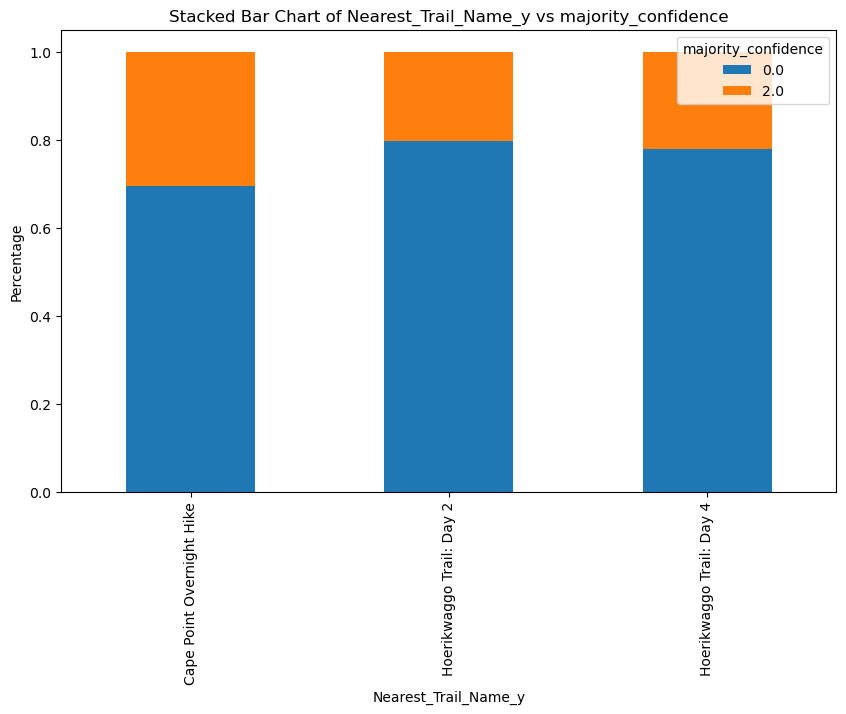

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a stacked bar chart
stacked = pd.crosstab(small_trail['Nearest_Trail_Name_y'], small_trail['majority_confidence'], normalize='index')
stacked.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Bar Chart of Nearest_Trail_Name_y vs majority_confidence')
plt.ylabel('Percentage')
plt.show()

This shows that forest fires are more likely to occur at Cape Point than the other two trails

4) Choose and Train Models

In [26]:
print(small_trail['Nearest_Trail_Name_y'].unique())

['Hoerikwaggo Trail: Day 4' 'Hoerikwaggo Trail: Day 2'
 'Cape Point Overnight Hike']


In [27]:

# Manual mapping
mapping = {'Cape Point Overnight Hike': 0, 'Hoerikwaggo Trail:Day 2': 1, 'Hoerikwaggo Trail:Day 4': 2}
small_trail['Nearest_Trail_Name_y'] = small_trail['Nearest_Trail_Name_y'].map(mapping)
# print(small_trail.head(2))

model_data = small_trail[['Date', 'Nearest_Trail_Name_y','Maximum Temperature','Minimum Temperature','majority_confidence']]

model_data = small_trail[['Nearest_Trail_Name_y', 'Date', 'Maximum Temperature','Minimum Temperature', 'majority_confidence']].copy()

try:
    model_data['Date'] = pd.to_datetime(model_data['Date'])
    model_data['Month'] = model_data['Date'].dt.month
except Exception as e:
    print(f"Failed to convert Date column: {e}")

model_data['Nearest_Trail_Name_y'] = model_data['Nearest_Trail_Name_y'].astype('category')

print(model_data.head(10))


     Nearest_Trail_Name_y       Date  Maximum Temperature Minimum Temperature  \
1401                  NaN 2012-01-27                 80.0                58.0   
1404                  NaN 2012-01-27                 76.0                58.0   
1409                  NaN 2012-01-27                 96.0                58.0   
1410                  NaN 2012-01-27                 91.0                60.0   
1411                  NaN 2012-01-27                 93.0                58.0   
1414                  NaN 2012-01-27                 85.0                60.0   
1417                  NaN 2012-01-27                 69.0                56.0   
1420                  NaN 2012-01-27                 96.0                56.0   
1423                  NaN 2012-01-27                 82.0                51.0   
1426                  NaN 2012-01-27                 77.0                58.0   

      majority_confidence  Month  
1401                  2.0      1  
1404                  2.0      1  
140

/var/folders/td/yg52fd9j2w3dn5zt40tr44k40000gn/T/ipykernel_41266/945484568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_trail['Nearest_Trail_Name_y'] = small_trail['Nearest_Trail_Name_y'].map(mapping)


In [28]:
X = model_data.iloc[:, [2, 3, 5]]
y = model_data.iloc[:, 4]
# Drop rows with any NaN values
X = X.dropna()
y = y[X.index]  
print("Shape of my target column is" + " " + str(y.shape))
print("Shape of my feature column is" + " " + str(X.shape))

Shape of my target column is (1622,)
Shape of my feature column is (1622, 3)


In [29]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

print(X_train)
print(y_train)

        Maximum Temperature Minimum Temperature  Month
130006                 99.0                61.0      1
160680                100.0                57.0     10
96770                  73.0                90.0      2
169853                 97.0                56.0      1
141684                 88.0                57.0      4
...                     ...                 ...    ...
93339                  84.0               102.0     12
28573                  66.0                83.0      1
129718                 76.0                83.0     12
129668                 76.0                94.0     12
160875                 92.0                64.0     10

[1297 rows x 3 columns]
130006    0.0
160680    0.0
96770     0.0
169853    0.0
141684    2.0
         ... 
93339     0.0
28573     2.0
129718    0.0
129668    0.0
160875    0.0
Name: majority_confidence, Length: 1297, dtype: float64


In [30]:
# Implementing logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the model
model = LogisticRegression()

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7938461538461539


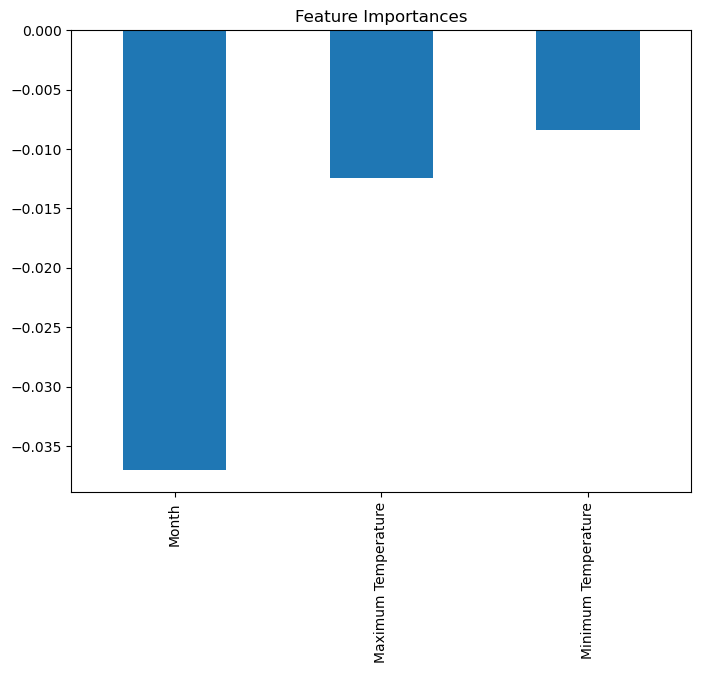

In [31]:
# importance for each feature to the target column
coefficients = pd.DataFrame(model.coef_[0], index=X_train.columns, columns=['Coefficient'])
coefficients.sort_values('Coefficient', inplace=True)

plt.figure(figsize=(8, 6))
coefficients['Coefficient'].plot(kind='bar')
plt.title('Feature Importances')
plt.show()


Can we improve while still using the same model?

In [32]:
# Cited from https://github.com/Qunlexie/A-Comprehensive-Classification-Model-for-Predicting-Wildfires-with-Uncertainty/blob/master/Wildfire%20Prediction.ipynb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),          # Scale features
    ('logreg', LogisticRegression())       # Logistic regression model
])

# Define a grid of parameters to search
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000000],   # Regularization strength
    'logreg__penalty': ['l1', 'l2'],              # Type of regularization
    'logreg__solver': ['liblinear', 'saga']       # Solvers that support L1 regularization
}

# Setup the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print best parameters found
print("Best parameters:", grid_search.best_params_)


Best parameters: {'logreg__C': 0.001, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [33]:
# Assuming X_test and y_test are your testing data and labels
y_pred = best_model.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Test set accuracy: 0.7938461538461539


Not really an improvement!

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

precision = precision_score(y_test, y_pred, pos_label=2.0)
recall = recall_score(y_test, y_pred, pos_label=2.0)
f1 = f1_score(y_test, y_pred, pos_label=2.0)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/brianmmari/miniforge3/envs/ros_base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


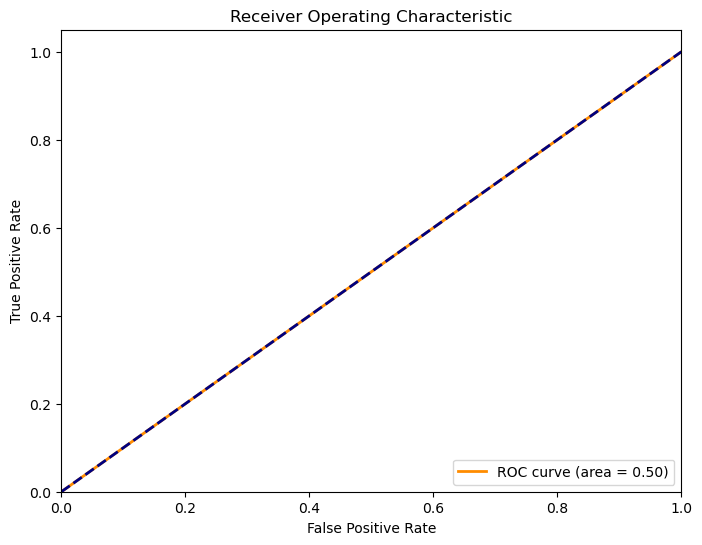

In [35]:
prob_pred = best_model.predict_proba(X_test)[:, 1]  # Index 1 assuming class 2.0 is the second column in predict_proba output

# Calculate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, prob_pred, pos_label=2.0)
roc_auc = auc(fpr, tpr)  # Calculate area under the curve

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Perhaps not as easy to obtain any higher accuracy while using logistic regression. Maybe consider other models

In [36]:
from sklearn.ensemble import RandomForestClassifier

X = small_trail.iloc[:, [4, 5, 6, 7]] # now include all the features, regardless if have NaN
y = small_trail.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100000, random_state=42)  # n_estimators is the number of trees

# Train the model
rf.fit(X_train, y_train)
# Make predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]  # Get probability scores for ROC AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")


Accuracy: 0.7572254335260116
ROC AUC: 0.5651184934405417


In [37]:
from sklearn.model_selection import GridSearchCV

# Define parameters to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score: 0.76


In [38]:
# Re-train with the best parameters
best_params_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_params_rf.fit(X_train, y_train)

# Re-evaluate
new_y_pred = best_params_rf.predict(X_test)
new_accuracy = accuracy_score(y_test, new_y_pred)
new_roc_auc = roc_auc_score(y_test, best_params_rf.predict_proba(X_test)[:, 1])

print(f"New Accuracy: {new_accuracy}")
print(f"New ROC AUC: {new_roc_auc}")


New Accuracy: 0.7832369942196532
New ROC AUC: 0.5916737198476514


Random Forests increased the accuracy of our model. We see an increased area for our ROC curve as well as a better test accuracy.
Let's checkk and see if other models can improve on forecasting 

In [39]:
# Try HistGradientBoostingClassifier Algorithm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report


X = model_data[['Month','Maximum Temperature', 'Minimum Temperature']]
y = model_data['majority_confidence']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Obtain the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)
print(classification_report(y_test, y_pred))

[[359  47]
 [ 43  70]]
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89       406
         2.0       0.60      0.62      0.61       113

    accuracy                           0.83       519
   macro avg       0.75      0.75      0.75       519
weighted avg       0.83      0.83      0.83       519



Because we're predicting forest fires we're most interested in false negatives. If the model predicts no forest fires, but then forest fires happen then that may cause causalties. Minimizing false negatives is my main priority then. From the diagram above, False negative rate is 43/(43 + 359) is around 10.7%. Let's see if we can minimize that. 

5)  Model Evaluation

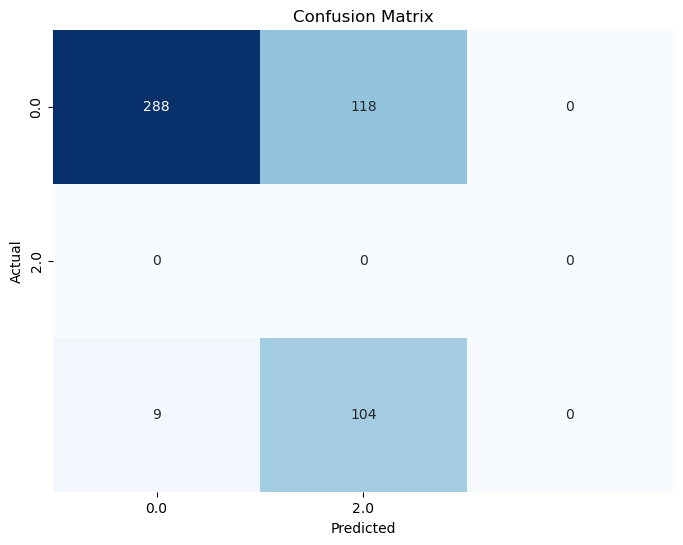

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82       406
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00       113

    accuracy                           0.55       519
   macro avg       0.32      0.24      0.27       519
weighted avg       0.76      0.55      0.64       519



/Users/brianmmari/miniforge3/envs/ros_base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianmmari/miniforge3/envs/ros_base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianmmari/miniforge3/envs/ros_base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

In [40]:
# Get the predicted probabilities for each class
y_probs = clf.predict_proba(X_test)

positive_probs = y_probs[:, 1]

# Adjust the threshold 
custom_threshold = 0.1
y_pred_custom = (positive_probs >= custom_threshold).astype(int)

# Obtain the new confusion matrix
new_conf_matrix = confusion_matrix(y_test, y_pred_custom)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model
print(classification_report(y_test, y_pred_custom))

Now we have a much better improved model. Our False negative rate is around 3%. 

<Figure size 1000x600 with 0 Axes>

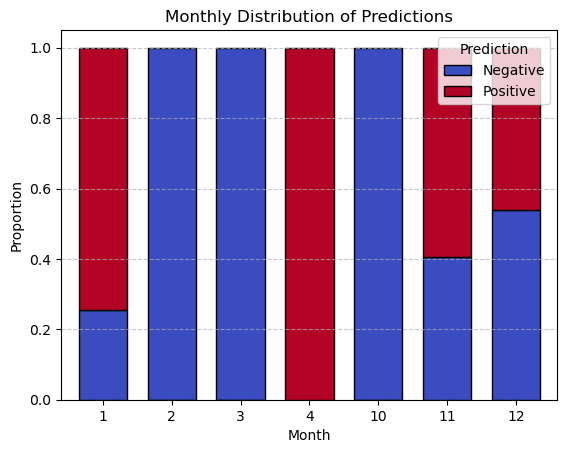

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add predictions to the test dataset
test_results = X_test.copy()
test_results['Predicted'] = y_pred_custom

# Include the actual values to compare (if needed)
test_results['Actual'] = y_test

# Group by 'Month' and aggregate by counting each class prediction
monthly_predictions = test_results.groupby('Month')['Predicted'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns for clarity if classes aren't already labeled
monthly_predictions.columns = ['Negative', 'Positive']  # Adjust based on your class labels

# Plot the proportions of positive vs negative predictions per month
plt.figure(figsize=(10, 6))
monthly_predictions.plot(kind='bar', stacked=True, colormap='coolwarm', edgecolor='k', width=0.7)

plt.title('Monthly Distribution of Predictions')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Prediction')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


The month with the highest positive predictions is April followed by January, November and then December. 

6) Conclusion
From the models analyzed, it is clear that the Histogram-Based Gradient Boosting Classifier is the best model for predicting forest fires.
It's faster and optimized for gradient boosting. I also realized perhaps the best way to view a good model is looking at the confusion matrix especially the false negative rate. A low number indicates a good model as discussed before. Logistic regression, though the simplest, was the worst model. Random Forests model did improve my accuracy from the original logistic regression, but this didn't really provide a better alternative compared to the Histogram-Based Gradient Boosting Classifier